### PCA in Machine Learning Workflows
#### Machine Learning I - Maestría en Analítica Aplicada
#### Universidad de la Sabana
#### Prof: Hugo Franco
#### Exercise: Dealing with Class Imbalance II

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score


1. Data Loading
Start by importing the libraries and loading the dataset and describe its contents

In [2]:
# Load the dataset
url = 'https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv'
df = pd.read_csv(url)

Dataset Shape: (7043, 21)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  P

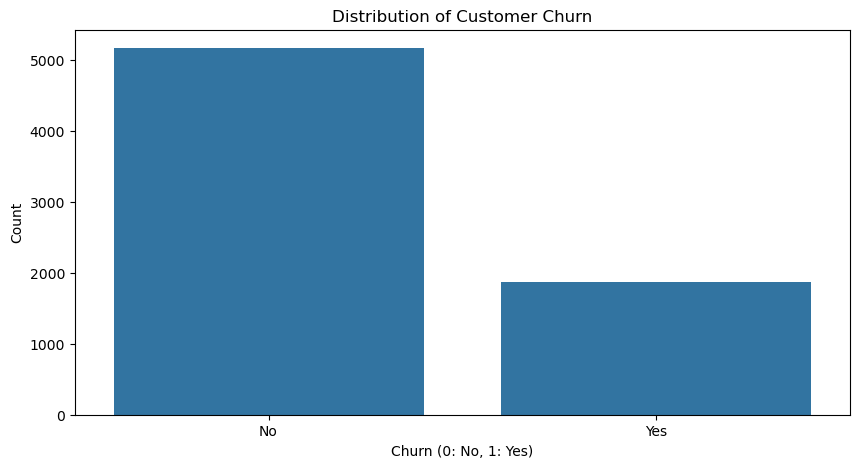


Missing Values:
Series([], dtype: int64)


In [6]:
# Dataset Overview Analysis
print("Dataset Shape:", df.shape)

# Display general information about the dataset
print("\nDataset Info:")
print(df.info())

# Show class distribution
print("\nChurn Distribution:")
print(df['Churn'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%')

# Display summary statistics for numerical features
numerical_features = df.select_dtypes(include=np.number).columns.tolist()
categorical_features = df.select_dtypes(exclude=np.number).columns.tolist()
print("\nNumerical Features Summary:")
print(df[numerical_features].describe())

# Show unique values in categorical features
print("\nCategorical Features Overview:")
for col in categorical_features:
    print(f"\n{col} unique values:")
    print(df[col].value_counts())

# Visualize class distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='Churn')
plt.title('Distribution of Customer Churn')
plt.xlabel('Churn (0: No, 1: Yes)')
plt.ylabel('Count')
plt.show()

# Display missing values if any
print("\nMissing Values:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

2. Data Preprocessing

Necessary preprocessing steps to clean the data and prepare it for the pipeline.

In [7]:
# --- Data Preprocessing ---

# Drop customerID
df.drop('customerID', axis=1, inplace=True)

# Handle 'TotalCharges' column
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)

# Convert 'Churn' and 'gender' to binary
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)
df['gender'] = df['gender'].apply(lambda x: 1 if x == 'Male' else 0)

# Separate features (X) and target (y)
X = df.drop('Churn', axis=1)
y = df['Churn']

# Identify feature types
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

# Create the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    # Keep the remaining columns (if any) unchanged
    remainder='passthrough'
)

# Split the data before applying any transformations
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

3. Build and Train the XGBoost Pipeline
Here, we define our three-step pipeline. When we call `.fit()`, it will automatically preprocess the data, apply SMOTE to the results, and then train the XGBoost classifier on the balanced data.

In [8]:
# --- Build and Train the Pipeline ---

# Import the necessary classes if they haven't been imported already
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline # Already imported, but good practice to be explicit

# Create the full pipeline with SMOTE and XGBoost
# This chains the preprocessor, the SMOTE balancing technique, and the classifier
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
])

# Train the entire pipeline on the training data
# The pipeline will handle preprocessing and balancing automatically
print("Training the pipeline...")
xgb_pipeline.fit(X_train, y_train)
print("Training complete.")

Training the pipeline...
Training complete.


c:\Users\Diegosuar\anaconda3\envs\mi_ambiente\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:57:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


4. Evaluate the Model
Finally, we use the trained pipeline to make predictions on the untouched test set and evaluate its performance.

 Classification Report:
              precision    recall  f1-score   support

    No Churn       0.85      0.84      0.85      1033
       Churn       0.58      0.60      0.59       374

    accuracy                           0.78      1407
   macro avg       0.72      0.72      0.72      1407
weighted avg       0.78      0.78      0.78      1407

 ROC AUC Score: 0.8232

 Confusion Matrix:


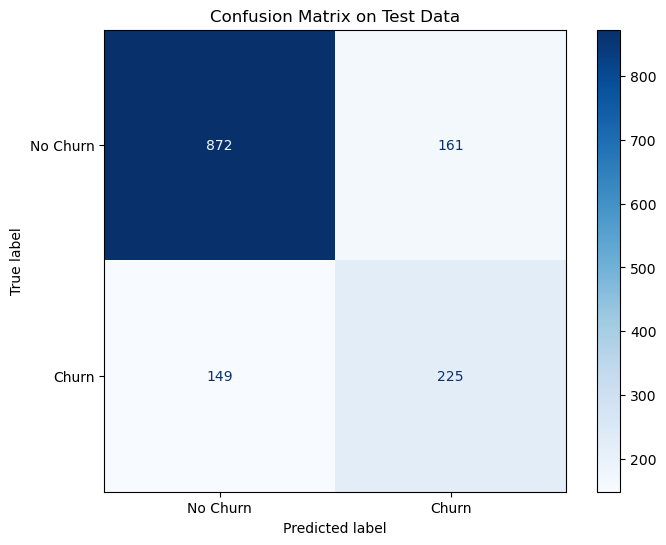

In [9]:
# --- Final Model Evaluation ---

# Import necessary metrics and plotting tools
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred = xgb_pipeline.predict(X_test)
# Predict probabilities for the positive class (Churn='Yes') for ROC AUC score
y_pred_proba = xgb_pipeline.predict_proba(X_test)[:, 1]

# --- Print the performance metrics ---

# 1. Classification Report
print(" Classification Report:")
print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))

# 2. ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f" ROC AUC Score: {roc_auc:.4f}\n")


# 3. Confusion Matrix
print(" Confusion Matrix:")
# Use ConfusionMatrixDisplay for a clean visualization
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(
    xgb_pipeline,
    X_test,
    y_test,
    display_labels=['No Churn', 'Churn'],
    cmap='Blues',
    ax=ax
)
plt.title('Confusion Matrix on Test Data')
plt.grid(False)
plt.show()

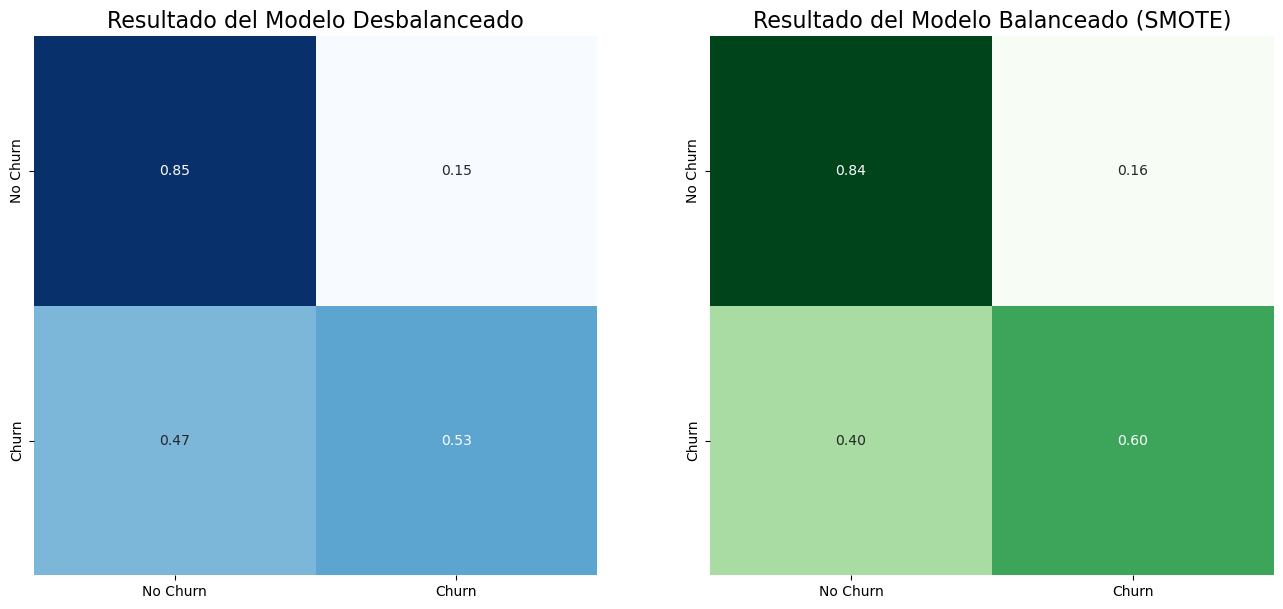

In [20]:
# --- Visualización Comparativa de Matrices de Confusión ---

# Se calculan las predicciones para ambos modelos (asumiendo que ya están entrenados)
y_pred_imbalanced = pipeline_imbalanced.predict(X_test)
y_pred_balanced = pipeline_balanced.predict(X_test)

# Se calculan las matrices normalizadas para ver las tasas de acierto
cm_imbalanced = confusion_matrix(y_test, y_pred_imbalanced, normalize='true')
cm_balanced = confusion_matrix(y_test, y_pred_balanced, normalize='true')

# Se crea la figura con los dos gráficos
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
class_names = ['No Churn', 'Churn']

# Matriz 1: Modelo Desbalanceado
sns.heatmap(cm_imbalanced, annot=True, fmt='.2f', ax=axes[0], cmap='Blues', cbar=False)
axes[0].set_title('Resultado del Modelo Desbalanceado', fontsize=16)
axes[0].set_xticklabels(class_names)
axes[0].set_yticklabels(class_names)

# Matriz 2: Modelo Balanceado con SMOTE
sns.heatmap(cm_balanced, annot=True, fmt='.2f', ax=axes[1], cmap='Greens', cbar=False)
axes[1].set_title('Resultado del Modelo Balanceado (SMOTE)', fontsize=16)
axes[1].set_xticklabels(class_names)
axes[1].set_yticklabels(class_names)

plt.show()